In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from get_metrics import *
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

print("Libraries imported")

Libraries imported


In [ ]:
datadir = '/content/drive/MyDrive/Project/Dataset'
trainingset = datadir+'/train/'
testingset = datadir+'/test/'

img_size = (320,320)
batch_size = 8

In [ ]:
mean1, std1 = [0.3017, 0.3017, 0.3017], [0.1913, 0.1913, 0.1913]
mean2, std2 = [0.3176, 0.3176, 0.3176], [0.1881, 0.1881, 0.1881]

data_transforms = {
    'train': transforms.Compose([
                                 transforms.Resize(img_size),
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean1, 
                                                  std = std1)
    ]),
    'test': transforms.Compose([
                                transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = mean2, 
                                                  std = std2)
    ]),
                   }

print("Initializing Datasets and Dataloaders...\n")

image_datasets = {'train' : datasets.ImageFolder(trainingset, data_transforms['train']), 
                  'test' : datasets.ImageFolder(testingset, data_transforms['test'])}

dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True),
               'test' : torch.utils.data.DataLoader(image_datasets['test'], 
                                                     batch_size = batch_size, shuffle = True,
                                                     num_workers=4, pin_memory=True)}

device = torch.device("cuda:0")
dataset_sizes = {'train' : len(image_datasets['train']),
                 'test' : len(image_datasets['test'])}
print("Initialized!")

Initializing Datasets and Dataloaders...

Initialized!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Class names convert to index
image_datasets['train'].class_to_idx
class_names=image_datasets['train'].classes
print(">>Class Names: {}\n".format(image_datasets['train'].classes))
print(">>Class Index: {}\n".format(image_datasets['train'].class_to_idx))
print(">>Number of images in training={}\n".format(dataset_sizes['train']))
print(">>Number of images in test={}\n".format(dataset_sizes['test']))
print("    Number of steps for training set={}\n".format(len(dataloaders['train'])))
print("    Number of steps for test set={}\n".format(len(dataloaders['test']))) 

>>Class Names: ['abnormal', 'normal']

>>Class Index: {'abnormal': 0, 'normal': 1}

>>Number of images in training=8379

>>Number of images in test=563

    Number of steps for training set=1048

    Number of steps for test set=71



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


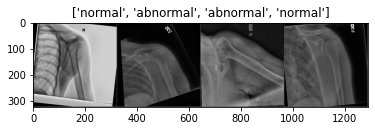

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean1)
    std = np.array(std1)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
inputs = [inputs[x] for x in [0,1,2,3]]
classes = [classes[x] for x in [0,1,2,3]]
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
class SpinalNet_Res(nn.Module):

  def __init__(self):
    super(SpinalNet_Res, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Linear(half_input_size, layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Linear(layer_width*4,2),nn.Sigmoid())

  def forward(self, x):
    x1 = self.fc_spinal_layer1(x[:, 0:half_input_size])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, half_input_size:2*half_input_size], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:half_input_size], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, half_input_size:2*half_input_size], x3], dim=1))

    x = torch.cat([x1,x2], dim=1)
    x = torch.cat([x,x3], dim=1)
    x = torch.cat([x,x4], dim=1)

    x=self.fc_out(x)
    return x

In [ ]:
class SpinalNet_Dense(nn.Module):
  def __init__(self):
    super(SpinalNet_Dense, self).__init__()

    self.fc_spinal_layer1 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(half_input_size, layer_width),
        nn.BatchNorm1d(layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer2 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer3 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width),
        nn.ReLU(inplace=True),)
    self.fc_spinal_layer4 = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(half_input_size+layer_width, layer_width),
        nn.BatchNorm1d(layer_width),
        nn.ReLU(inplace=True),)
    self.fc_out = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(layer_width*4, 2), nn.Sigmoid())
  
  def forward(self, x):
    x1 = self.fc_spinal_layer1(x[:, 0:half_input_size])
    x2 = self.fc_spinal_layer2(torch.cat([x[:, half_input_size:2*half_input_size], x1], dim=1))
    x3 = self.fc_spinal_layer3(torch.cat([x[:, 0:half_input_size], x2], dim=1))
    x4 = self.fc_spinal_layer4(torch.cat([x[:, half_input_size:2*half_input_size], x3], dim=1))

    x = torch.cat([x1,x2], dim=1)
    x = torch.cat([x, x3], dim=1)
    x = torch.cat([x, x4], dim=1)

    x = self.fc_out(x)
    return x

**Training the models**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_weights = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  ghost=True
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        #forward, track history only if we are in training
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          #backward + optimize only if we are in training
          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.detach() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss/dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      #storing losses and accuracy per epochs to plot metrics graph

      if phase == 'train':
        train_losses.append(epoch_loss)
        train_acc.append(epoch_acc)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'test':
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        test_losses.append(epoch_loss)
        test_acc.append(epoch_acc)
      torch.cuda.empty_cache()


      #deep copy the model
      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_weights = copy.deepcopy(model.state_dict())
    
    print()
    torch.cuda.empty_cache()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_weights)
  torch.save(best_model_weights, "./model.pth")
  return model

**ResNeXt50 with Spinal FC**

In [ ]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []

In [ ]:
model_ft =models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
layer_width = 20
half_input_size = round(num_ftrs/2)
model_ft.fc = SpinalNet_Res()

model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas = (0.9, 0.999), lr=0.0001)
#decay of LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,40)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.5953 Acc: 0.6948
train Loss: 0.5953 Acc: 0.6948
test Loss: 0.5559 Acc: 0.7371
test Loss: 0.5559 Acc: 0.7371

Epoch 1/39
----------
train Loss: 0.5648 Acc: 0.7346
train Loss: 0.5648 Acc: 0.7346
test Loss: 0.5254 Acc: 0.7798
test Loss: 0.5254 Acc: 0.7798

Epoch 2/39
----------
train Loss: 0.5525 Acc: 0.7483
train Loss: 0.5525 Acc: 0.7483
test Loss: 0.5227 Acc: 0.7833
test Loss: 0.5227 Acc: 0.7833

Epoch 3/39
----------
train Loss: 0.5418 Acc: 0.7601
train Loss: 0.5418 Acc: 0.7601
test Loss: 0.5380 Acc: 0.7673
test Loss: 0.5380 Acc: 0.7673

Epoch 4/39
----------
train Loss: 0.5375 Acc: 0.7668
train Loss: 0.5375 Acc: 0.7668
test Loss: 0.5144 Acc: 0.7904
test Loss: 0.5144 Acc: 0.7904

Epoch 5/39
----------
train Loss: 0.5291 Acc: 0.7731
train Loss: 0.5291 Acc: 0.7731
test Loss: 0.5161 Acc: 0.7886
test Loss: 0.5161 Acc: 0.7886

Epoch 6/39
----------
train Loss: 0.5289 Acc: 0.7694
train Loss: 0.5289 Acc: 0.7694
test Loss: 0.5161 Acc: 0.7815
test Loss: 0.5161 Acc: 0.7815

Epoch 7

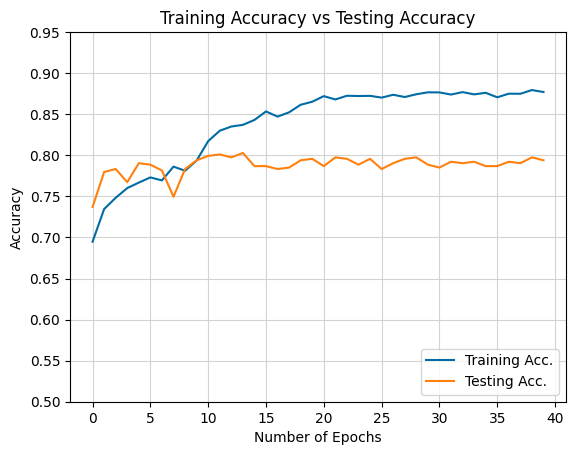

In [ ]:
matplotlib.rcdefaults()
epochs=range(0, 40, 1)
plt.plot(epochs, train_acc, color='#006BA4')
plt.plot(epochs, test_acc, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 600
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Testing Accuracy")
plt.legend(['Training Acc.', 'Testing Acc.'],loc='lower right')

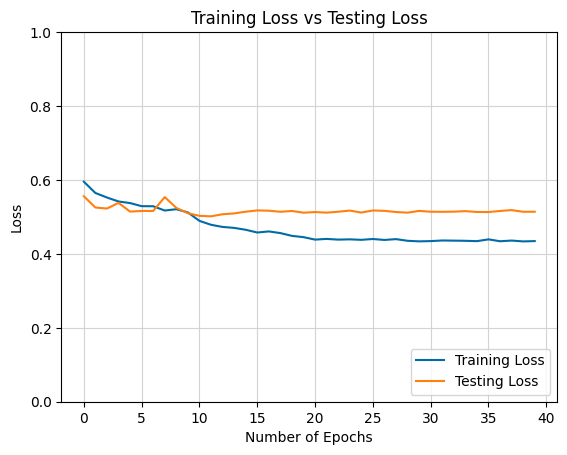

In [ ]:
#This code block draw graph for loss
matplotlib.rcdefaults()
plt.plot(epochs, train_losses, color='#006BA4')
plt.plot(epochs, test_losses, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Testing Loss")
plt.legend(['Training Loss', 'Testing Loss'],loc='lower right')

In [ ]:
get_metric.test_model(model_ft,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 452  Total Images: 563
Test Accuracy = 0.802842


In [ ]:
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.80      0.80      0.80       278
           1       0.81      0.80      0.80       285

    accuracy                           0.80       563
   macro avg       0.80      0.80      0.80       563
weighted avg       0.80      0.80      0.80       563



Confusion matrix:
 [[223  55]
 [ 56 229]]


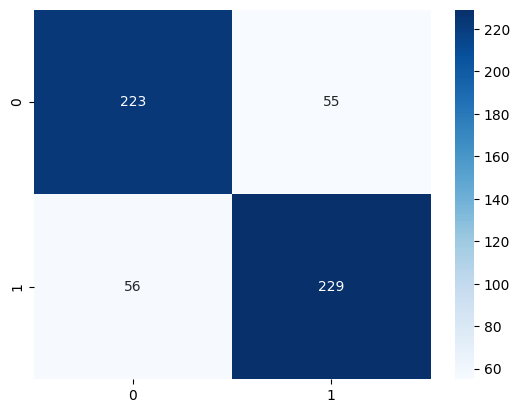

In [ ]:
get_metric.get_confusion_matrix(actuals, predictions)

In [ ]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6056402910385128


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Auc Score For Each Class:  {0: 0.8564937523665279, 1: 0.8569481257099583}


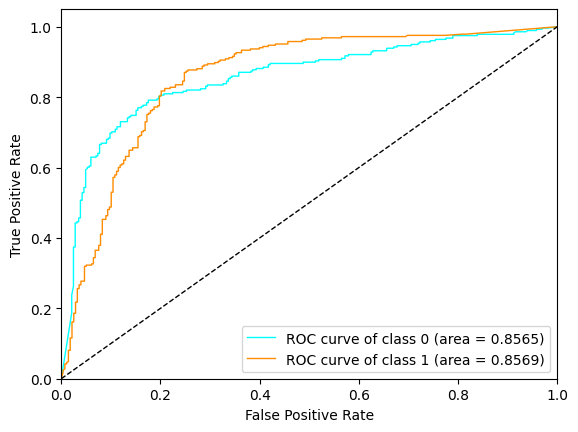

In [ ]:
get_metric.get_roc_curves(model_ft, device,  dataloaders['test'])

**DenseNet201 with Spinal FC**

In [ ]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []

In [ ]:
model_ft =models.densenet201(pretrained=True)
num_ftrs = model_ft.classifier.in_features
half_input_size = round(num_ftrs/2)
layer_width = 240
model_ft.classifier = SpinalNet_Dense()

model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas = (0.9, 0.999), lr=0.0001)
#decay of LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,40)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6019 Acc: 0.6911
train Loss: 0.6019 Acc: 0.6911
test Loss: 0.5521 Acc: 0.7442
test Loss: 0.5521 Acc: 0.7442

Epoch 1/39
----------
train Loss: 0.5624 Acc: 0.7379
train Loss: 0.5624 Acc: 0.7379
test Loss: 0.5413 Acc: 0.7620
test Loss: 0.5413 Acc: 0.7620

Epoch 2/39
----------
train Loss: 0.5577 Acc: 0.7447
train Loss: 0.5577 Acc: 0.7447
test Loss: 0.5190 Acc: 0.7851
test Loss: 0.5190 Acc: 0.7851

Epoch 3/39
----------
train Loss: 0.5462 Acc: 0.7567
train Loss: 0.5462 Acc: 0.7567
test Loss: 0.5529 Acc: 0.7442
test Loss: 0.5529 Acc: 0.7442

Epoch 4/39
----------
train Loss: 0.5428 Acc: 0.7613
train Loss: 0.5428 Acc: 0.7613
test Loss: 0.5419 Acc: 0.7584
test Loss: 0.5419 Acc: 0.7584

Epoch 5/39
----------
train Loss: 0.5334 Acc: 0.7735
train Loss: 0.5334 Acc: 0.7735
test Loss: 0.5613 Acc: 0.7442
test Loss: 0.5613 Acc: 0.7442

Epoch 6/39
----------
train Loss: 0.5320 Acc: 0.7707
train Loss: 0.5320 Acc: 0.7707
test Loss: 0.5273 Acc: 0.7762
test Loss: 0.5273 Acc: 0.7762

Epoch 7

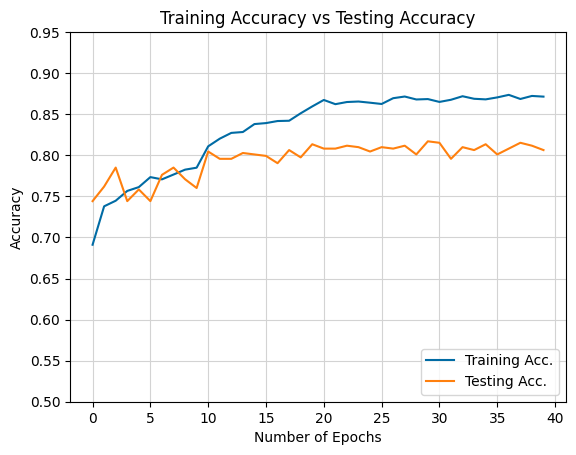

In [ ]:
matplotlib.rcdefaults()
epochs=range(0, 40, 1)
plt.plot(epochs, train_acc, color='#006BA4')
plt.plot(epochs, test_acc, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 600
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Testing Accuracy")
plt.legend(['Training Acc.', 'Testing Acc.'],loc='lower right')

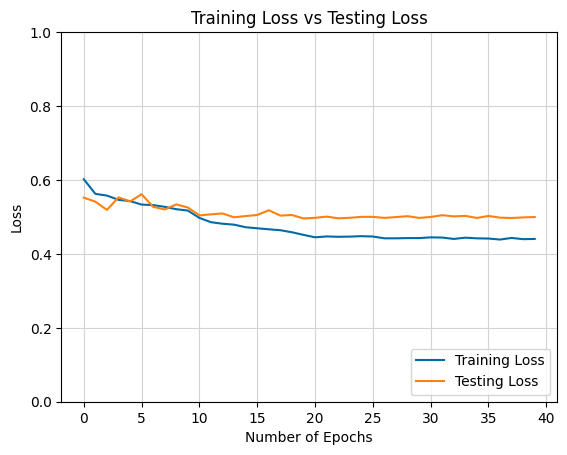

In [ ]:
#This code block draw graph for loss
matplotlib.rcdefaults()
plt.plot(epochs, train_losses, color='#006BA4')
plt.plot(epochs, test_losses, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Testing Loss")
plt.legend(['Training Loss', 'Testing Loss'],loc='lower right')

In [ ]:
get_metric.test_model(model_ft,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 460  Total Images: 563
Test Accuracy = 0.817052


In [ ]:
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.79      0.81       278
           1       0.81      0.84      0.82       285

    accuracy                           0.82       563
   macro avg       0.82      0.82      0.82       563
weighted avg       0.82      0.82      0.82       563



Confusion matrix:
 [[220  58]
 [ 45 240]]


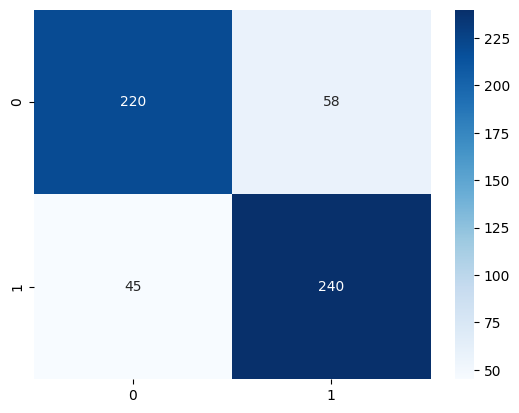

In [ ]:
get_metric.get_confusion_matrix(actuals, predictions)

In [ ]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.6338361674317574


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Auc Score For Each Class:  {0: 0.8669127855610248, 1: 0.8680234759560773}


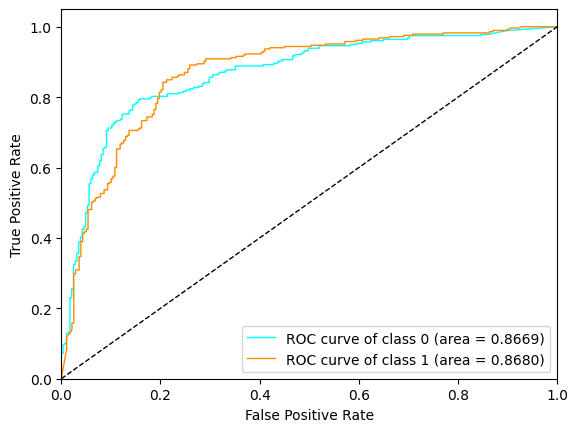

In [ ]:
get_metric.get_roc_curves(model_ft, device,  dataloaders['test'])

**ResNet34 with Spinal FC**

In [ ]:
train_losses = []
train_acc = []
test_losses = []
test_acc = []

In [ ]:
model_ft=models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
layer_width = 256
half_input_size = round(num_ftrs/2)
model_ft.fc = SpinalNet_Res()

model_ft = model_ft.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), betas = (0.9, 0.999), lr=0.0001)
#decay of LR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler,40)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 0.6091 Acc: 0.6815
train Loss: 0.6091 Acc: 0.6815
test Loss: 0.5457 Acc: 0.7602
test Loss: 0.5457 Acc: 0.7602

Epoch 1/39
----------
train Loss: 0.5838 Acc: 0.7132
train Loss: 0.5838 Acc: 0.7132
test Loss: 0.6624 Acc: 0.6057
test Loss: 0.6624 Acc: 0.6057

Epoch 2/39
----------
train Loss: 0.5616 Acc: 0.7389
train Loss: 0.5616 Acc: 0.7389
test Loss: 0.5579 Acc: 0.7460
test Loss: 0.5579 Acc: 0.7460

Epoch 3/39
----------
train Loss: 0.5521 Acc: 0.7487
train Loss: 0.5521 Acc: 0.7487
test Loss: 0.5253 Acc: 0.7709
test Loss: 0.5253 Acc: 0.7709

Epoch 4/39
----------
train Loss: 0.5494 Acc: 0.7545
train Loss: 0.5494 Acc: 0.7545
test Loss: 0.5358 Acc: 0.7620
test Loss: 0.5358 Acc: 0.7620

Epoch 5/39
----------
train Loss: 0.5461 Acc: 0.7568
train Loss: 0.5461 Acc: 0.7568
test Loss: 0.5661 Acc: 0.7478
test Loss: 0.5661 Acc: 0.7478

Epoch 6/39
----------
train Loss: 0.5345 Acc: 0.7683
train Loss: 0.5345 Acc: 0.7683
test Loss: 0.5475 Acc: 0.7513
test Loss: 0.5475 Acc: 0.7513

Epoch 7

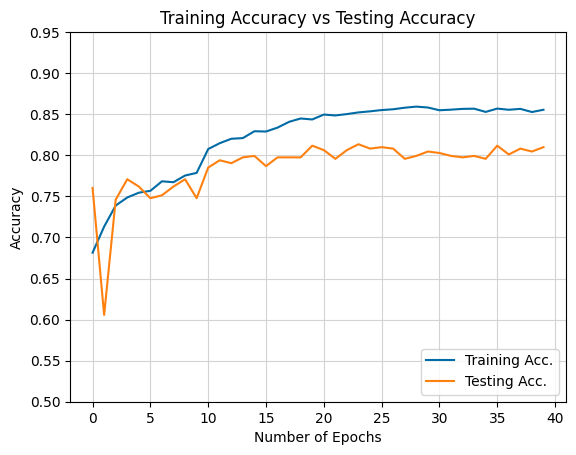

In [ ]:
matplotlib.rcdefaults()
epochs=range(0, 40, 1)
plt.plot(epochs, train_acc, color='#006BA4')
plt.plot(epochs, test_acc, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0.5, 1, 0.05))
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 600
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Testing Accuracy")
plt.legend(['Training Acc.', 'Testing Acc.'],loc='lower right')

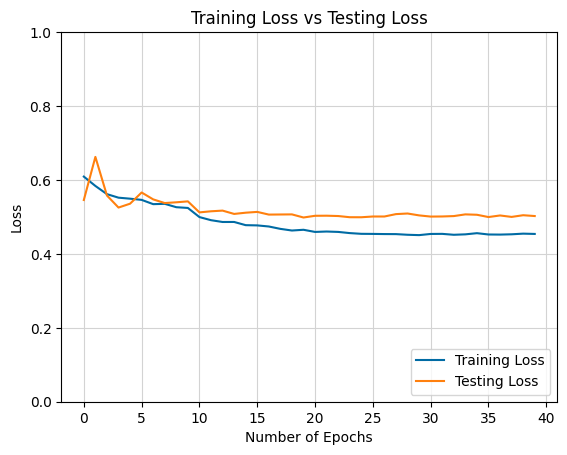

In [ ]:
#This code block draw graph for loss
matplotlib.rcdefaults()
plt.plot(epochs, train_losses, color='#006BA4')
plt.plot(epochs, test_losses, color='#FF800E')
plt.grid(b=True, which='major', color='lightgray')
plt.grid(b=True, which='minor', color='lightgray')
plt.xticks(np.arange(0, 45, 5))
plt.yticks(np.arange(0, 1.2, 0.2))
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Testing Loss")
plt.legend(['Training Loss', 'Testing Loss'],loc='lower right')

In [ ]:
get_metric.test_model(model_ft,device,dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Correct Prediction: 458  Total Images: 563
Test Accuracy = 0.813499


In [ ]:
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
get_metric.get_classification_report(actuals, predictions)

Classification Report :
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       278
           1       0.82      0.81      0.82       285

    accuracy                           0.81       563
   macro avg       0.81      0.81      0.81       563
weighted avg       0.81      0.81      0.81       563



Confusion matrix:
 [[226  52]
 [ 53 232]]


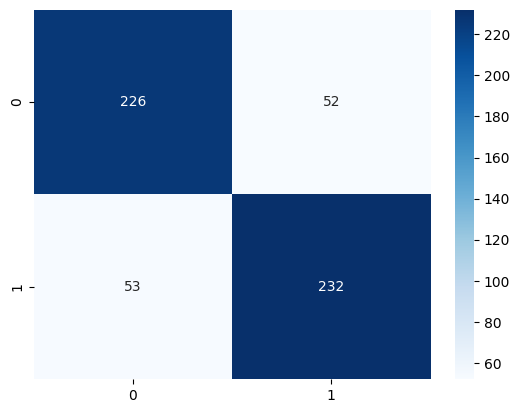

In [ ]:
get_metric.get_confusion_matrix(actuals, predictions)

In [ ]:
get_metric.get_cohen_kappa(actuals, predictions)

Kappa Score of this model:
 0.626957032063458


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Auc Score For Each Class:  {0: 0.8593840716900163, 1: 0.8598510665152089}


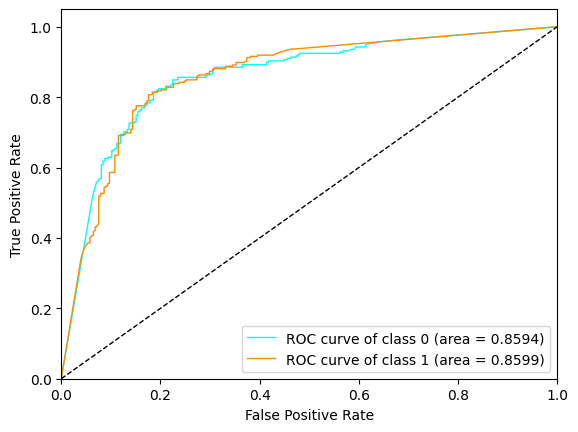

In [ ]:
get_metric.get_roc_curves(model_ft, device,  dataloaders['test'])